https://youtu.be/83tnWs_YBRQ

In [1]:
# # Install the required libraries
# #SAM
# !pip install git+https://github.com/facebookresearch/segment-anything.git
# #Transformers
# !pip install -q git+https://github.com/huggingface/transformers.git
# #Datasets to prepare data and monai if you want to use special loss functions
# !pip install datasets
# !pip install -q monai
# #Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)
# !pip install patchify

In [2]:
# !pip uninstall -y numpy



In [3]:
# !pip install numpy==2.0.2



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import os
import random
from scipy import ndimage

from datasets import Dataset
from PIL import Image



In [2]:

images_dir = '/content/content/patches/train/images'
masks_dir = '/content/content/patches/train/masks'

image_files = sorted([f for f in os.listdir(images_dir) if f.endswith(".npy")])
mask_files = sorted([f for f in os.listdir(masks_dir) if f.endswith(".npy")])

# dataset = {
#     "image": [Image.fromarray(np.load(os.path.join(images_dir, f))) for f in image_files],
#     "label": [Image.fromarray(np.load(os.path.join(masks_dir, f))) for f in mask_files],
# }

dataset = {
    "image": [np.load(os.path.join(images_dir, f)) for f in image_files],
    "label": [np.load(os.path.join(masks_dir, f)) for f in mask_files],
}

print(f"Loaded {len(dataset['image'])} images and {len(dataset['label'])} masks")


Loaded 119 images and 119 masks


Let us make sure out images and masks (labels) are loading appropriately

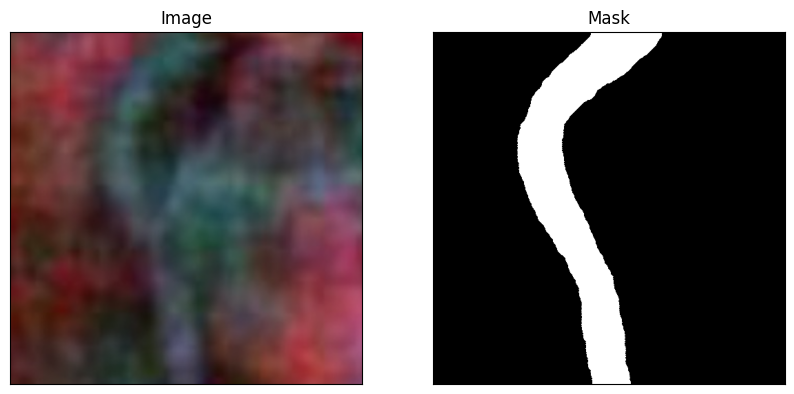

In [3]:
img_num = random.randint(0, len(image_files)-1)
example_image = dataset["image"][img_num]
example_mask = dataset["label"][img_num]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

Get bounding boxes from masks. You can get here directly if you are working with coco style annotations where bounding boxes are captured in a JSON file.

In [4]:
def get_random_point(ground_truth_map):
    """
    Возвращает случайную точку внутри маски (ground_truth_map > 0)
    При каждом вызове — новая случайная точка
    """
    y_indices, x_indices = np.where(ground_truth_map > 0)

    if len(x_indices) == 0 or len(y_indices) == 0:
        # Если маска пустая, возвращаем центр изображения
        return []

    # Случайно выбираем один индекс из всех индексов, которые входят в маску
    idx = np.random.randint(0, len(x_indices))
    x_point = x_indices[idx]
    y_point = y_indices[idx]

    return [x_point, y_point]


In [27]:
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF
import torch

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    image = self.dataset["image"][idx]
    ground_truth_mask = self.dataset["label"][idx]

    # get bounding box prompt
    prompt = get_random_point(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_points=[[prompt]], return_tensors="pt", size={"longest_edge": 512})

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    ground_truth_mask_tensor = torch.tensor(ground_truth_mask).unsqueeze(0)  # [1, H, W]
    # H, W = inputs["pixel_values"].shape[1:]  # [C, H, W]

    # ground_truth_mask_tensor= TF.resize(
    #     ground_truth_mask_tensor,
    #     size=(H, W),
    #     interpolation=TF.InterpolationMode.NEAREST
    # ).squeeze(0)  # обратно [H, W]

    inputs["ground_truth_mask"] = ground_truth_mask_tensor

    return inputs

In [6]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [7]:
# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [9]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)


<class 'numpy.ndarray'>
pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_points torch.Size([1, 1, 2])
ground_truth_mask torch.Size([1, 512, 512])


In [10]:
# Create a DataLoader instance for the training dataset
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, drop_last=False)

In [11]:
# Load the model
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [12]:
from torch.optim import Adam
import monai
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

<frozen importlib._bootstrap_external>:1301: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.


In [28]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize
import torch.nn.functional as F

#Training loop
num_epochs = 10

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):

      # 1. Подготовка данных
      pixel_values = batch["pixel_values"].to(device)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device) # [B, 1, 512, 512]

      # ИСПРАВЛЕНИЕ ВХОДА:
      # DataLoader выдает [Batch, 1, 2] или [Batch, 1, 1, 2].
      # Нам нужно строго [Batch, 1, 1, 2].
      input_points = batch["input_points"].to(device)
      if input_points.dim() == 3:
          input_points = input_points.unsqueeze(1) # Превращаем [B, 1, 2] -> [B, 1, 1, 2]

      # 2. Forward pass
      outputs = model(pixel_values=pixel_values,
                      input_points=input_points,
                      multimask_output=False)

      # ИСПРАВЛЕНИЕ ВЫХОДА:
      # Выход модели: [Batch, Point_Batch, Num_Masks, H, W] -> [B, 1, 1, 256, 256]
      predicted_masks = outputs.pred_masks.squeeze(1) # Убираем Point_Batch -> [B, 1, 256, 256]

      # 3. Интерполяция (Upsampling)
      # Растягиваем с 256 до 512, чтобы совпадало с Ground Truth
      predicted_masks = F.interpolate(
          predicted_masks,
          size=(512, 512),
          mode="bilinear",
          align_corners=False
      )

      # Теперь predicted_masks: [B, 1, 512, 512]
      # ground_truth_masks:   [B, 1, 512, 512]

      # 4. Считаем Loss
      loss = seg_loss(predicted_masks, ground_truth_masks)

      # Backward pass
      optimizer.zero_grad()
      loss.backward()

      # Optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')


  0%|          | 0/1 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


EPOCH: 0
Mean loss: 0.943157434463501


  0%|          | 0/1 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


EPOCH: 1
Mean loss: 1.0284069776535034


  0%|          | 0/1 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


EPOCH: 2
Mean loss: 1.0889651775360107


  0%|          | 0/1 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


EPOCH: 3
Mean loss: 1.060420036315918


  0%|          | 0/1 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


EPOCH: 4
Mean loss: 1.0431715250015259


  0%|          | 0/1 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


EPOCH: 5
Mean loss: 1.1451855897903442


  0%|          | 0/1 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


EPOCH: 6
Mean loss: 0.9182459712028503


  0%|          | 0/1 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


EPOCH: 7
Mean loss: 0.8735156059265137


  0%|          | 0/1 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


EPOCH: 8
Mean loss: 0.840362012386322


  0%|          | 0/1 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

EPOCH: 9
Mean loss: 0.8907331228256226


In [ ]:
# Save the model's state dictionary to a file
torch.save(model.state_dict(), "/content/drive/MyDrive/ColabNotebooks/models/SAM/mito_model_checkpoint.pth")

**Inference**

In [ ]:
from transformers import SamModel, SamConfig, SamProcessor
import torch

In [ ]:
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
my_mito_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
my_mito_model.load_state_dict(torch.load("/content/drive/MyDrive/ColabNotebooks/models/SAM/mito_full_data_10_epochs_model_checkpoint.pth"))

In [ ]:
# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
my_mito_model.to(device)

In [ ]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt

# let's take a random training example
idx = random.randint(0, filtered_images.shape[0]-1)

# load image
test_image = dataset[idx]["image"]

# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(dataset[idx]["label"])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

my_mito_model.eval()

# forward pass
with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Plot the second image on the right
axes[2].imshow(medsam_seg_prob)  # Assuming the second image is grayscale
axes[2].set_title("Probability Map")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()


Now, let us load a new image and segment it using our trained model. NOte that we need to provide some prompt. Since we do not know where the objects are going to be we cannot supply bounding boxes. So let us provide a grid of points as our prompt.

In [ ]:
#Apply a trained model on large image
large_test_images = tifffile.imread("/content/drive/MyDrive/ColabNotebooks/data/mitochondria/small_dataset_for_training/images/12_training_mito_images.tif")
large_test_image = large_test_images[1]
patches = patchify(large_test_image, (256, 256), step=256)  #Step=256 for 256 patches means no overlap


In [ ]:
"""
input_points (torch.FloatTensor of shape (batch_size, num_points, 2)) —
Input 2D spatial points, this is used by the prompt encoder to encode the prompt.
Generally yields to much better results. The points can be obtained by passing a
list of list of list to the processor that will create corresponding torch tensors
of dimension 4. The first dimension is the image batch size, the second dimension
is the point batch size (i.e. how many segmentation masks do we want the model to
predict per input point), the third dimension is the number of points per segmentation
mask (it is possible to pass multiple points for a single mask), and the last dimension
is the x (vertical) and y (horizontal) coordinates of the point. If a different number
of points is passed either for each image, or for each mask, the processor will create
“PAD” points that will correspond to the (0, 0) coordinate, and the computation of the
embedding will be skipped for these points using the labels.

"""
# Define the size of your array
array_size = 256

# Define the size of your grid
grid_size = 10

# Generate the grid points
x = np.linspace(0, array_size-1, grid_size)
y = np.linspace(0, array_size-1, grid_size)

# Generate a grid of coordinates
xv, yv = np.meshgrid(x, y)

# Convert the numpy arrays to lists
xv_list = xv.tolist()
yv_list = yv.tolist()

# Combine the x and y coordinates into a list of list of lists
input_points = [[[int(x), int(y)] for x, y in zip(x_row, y_row)] for x_row, y_row in zip(xv_list, yv_list)]

#We need to reshape our nxn grid to the expected shape of the input_points tensor
# (batch_size, point_batch_size, num_points_per_image, 2),
# where the last dimension of 2 represents the x and y coordinates of each point.
#batch_size: The number of images you're processing at once.
#point_batch_size: The number of point sets you have for each image.
#num_points_per_image: The number of points in each set.
input_points = torch.tensor(input_points).view(1, 1, grid_size*grid_size, 2)

In [ ]:
print(np.array(input_points).shape)

In [ ]:
patches.shape

In [ ]:
# Select a random patch for segmentation

# Compute the total number of 256x256 arrays
#num_arrays = patches.shape[0] * patches.shape[1]
# Select a random index
#index = np.random.choice(num_arrays)
# Compute the indices in the original array
#i = index // patches.shape[1]
#j = index % patches.shape[1]

#Or pick a specific patch for study.
i, j = 1, 2

# Selectelected patch for segmentation
random_array = patches[i, j]


single_patch = Image.fromarray(random_array)
# prepare image for the model

#First try without providing any prompt (no bounding box or input_points)
#inputs = processor(single_patch, return_tensors="pt")
#Now try with bounding boxes. Remember to uncomment.
inputs = processor(single_patch, input_points=input_points, return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}
my_mito_model.eval()


# forward pass
with torch.no_grad():
  outputs = my_mito_model(**inputs, multimask_output=False)

# apply sigmoid
single_patch_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
single_patch_prob = single_patch_prob.cpu().numpy().squeeze()
single_patch_prediction = (single_patch_prob > 0.5).astype(np.uint8)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(single_patch), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(single_patch_prob)  # Assuming the second image is grayscale
axes[1].set_title("Probability Map")

# Plot the second image on the right
axes[2].imshow(single_patch_prediction, cmap='gray')  # Assuming the second image is grayscale
axes[2].set_title("Prediction")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()